In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from wordcloud import WordCloud
import squarify
from sklearn.linear_model import LinearRegression
import numpy as np 
import matplotlib.cm as cm # For color maps

In [2]:
movies = pd.read_csv("data/processed/Movies.csv")
keywords = pd.read_csv("data/processed/Keywords.csv")
ratings = pd.read_csv("data/processed/Ratings.csv")

In [4]:
print("Movies:", movies.columns)
print("Keywords:", keywords.columns)
print("Ratings:", ratings.columns)

Movies: Index(['genres', 'id', 'overview', 'poster_path', 'release_date', 'runtime',
       'title', 'genres_parsed'],
      dtype='object')
Keywords: Index(['id', 'keywords'], dtype='object')
Ratings: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [3]:
# Parse dates
movies["release_date"] = pd.to_datetime(movies["release_date"])
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"])
movies["year"] = movies["release_date"].dt.year
ratings["year"] = ratings["timestamp"].dt.year

In [4]:
ratings.head(20)

,userId,movieId,rating,timestamp,year
0,1,110,1.0,2015-03-09 22:52:09,2015
1,2,605,4.0,1997-06-23 04:26:13,1997
2,2,786,1.0,1997-06-23 04:14:09,1997
3,2,1552,2.0,1997-06-23 04:38:55,1997
4,3,500,2.0,2003-03-19 12:29:05,2003
5,3,527,4.0,2003-03-19 12:28:20,2003
6,3,1092,3.0,2003-03-19 12:29:55,2003
7,4,415,4.0,2003-01-15 21:58:45,2003
8,4,1644,3.0,2003-01-15 23:54:05,2003
9,4,1732,3.0,2003-01-15 23:52:41,2003


In [5]:
movies.columns


Index(['genres', 'id', 'overview', 'poster_path', 'release_date', 'runtime',
       'title', 'genres_parsed', 'year'],
      dtype='object')

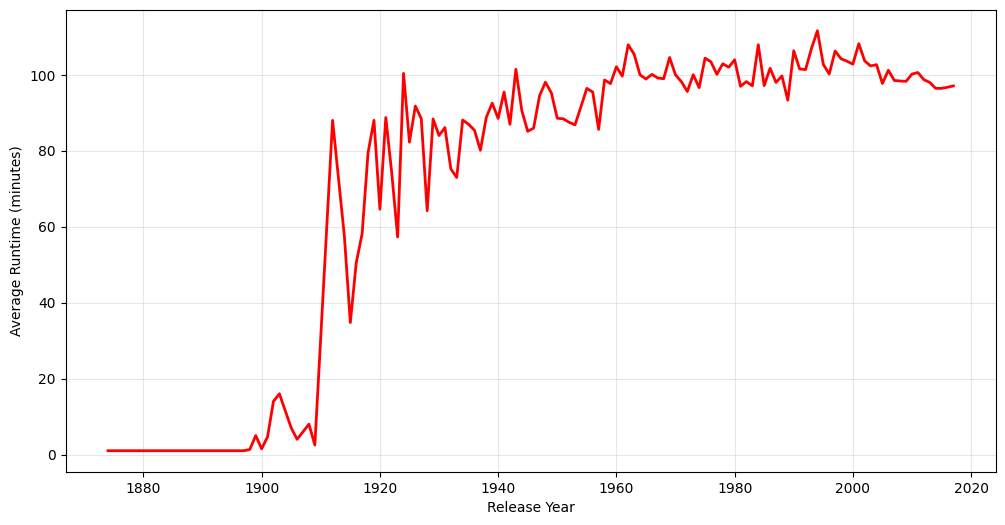

In [7]:
# Group by year and get the average runtime
runtime_by_year = movies[movies["runtime"] > 0].groupby("year")["runtime"].mean()

plt.figure(figsize=(12, 6))
plt.plot(runtime_by_year.index, runtime_by_year.values, color='red', linewidth=2)

plt.xlabel("Release Year")
plt.ylabel("Average Runtime (minutes)")
#plt.title("Average Movie Runtime Over Time")
plt.grid(True, alpha=0.3)
plt.show()

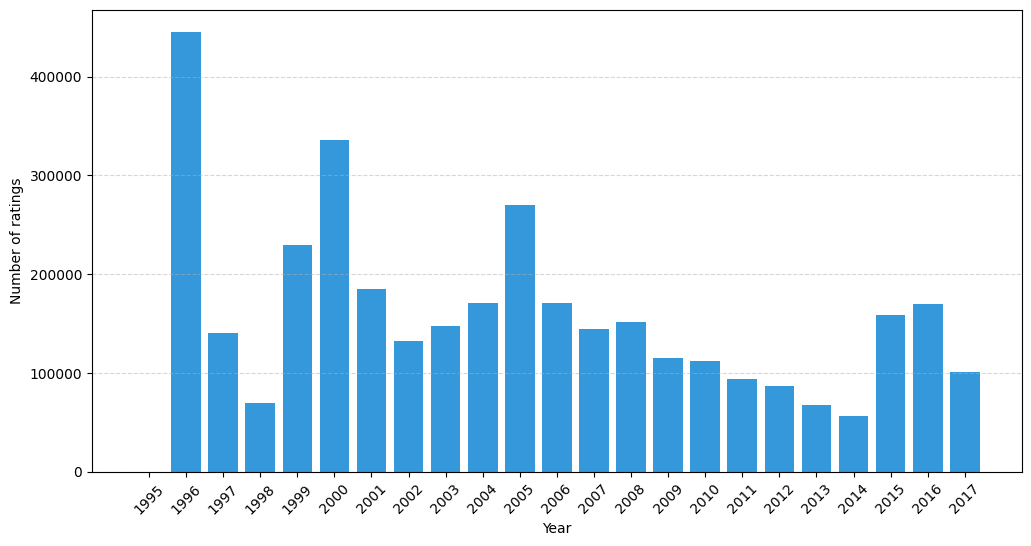

In [ ]:
# Count ratings per year first
ratings_per_year = ratings["year"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(
    ratings_per_year.index, 
    ratings_per_year.values, 
    width=0.8,       # Controls bar width (creates gaps)
    color='#3498db'  # A nice blue color
)

plt.xlabel("Year")
plt.ylabel("Number of ratings")
#plt.title("Distribution of Ratings per Year (Bar Chart)")

# Fix the x-axis ticks to show every year (or every 2 years if too crowded)
plt.xticks(ratings_per_year.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5) # Add grid lines for readability
plt.show()


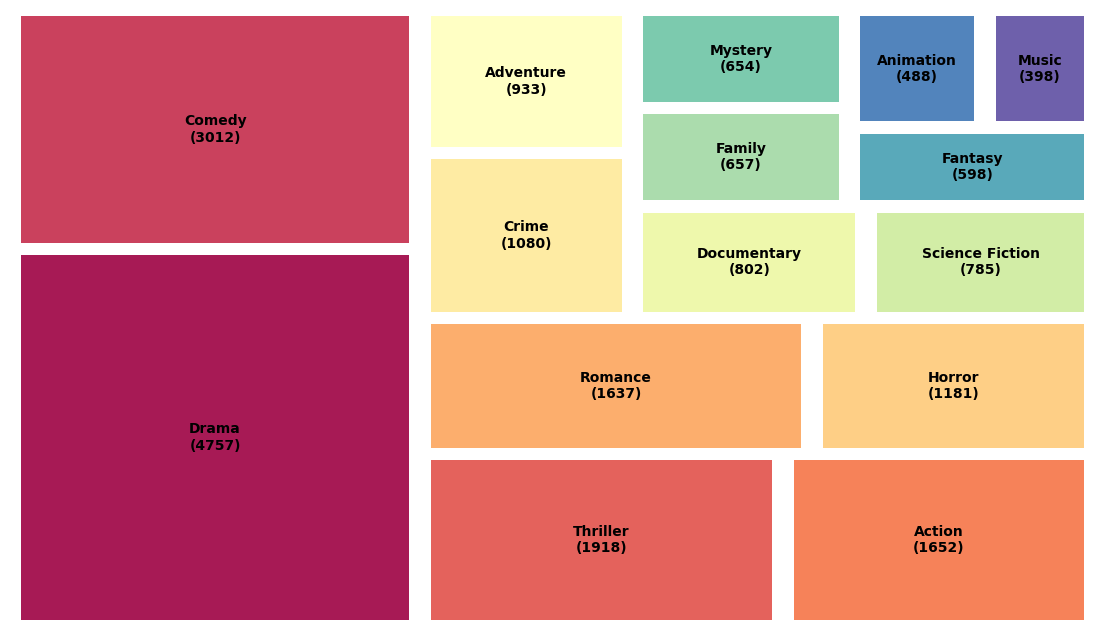

In [5]:
# Parse genres
movies["genres_parsed"] = movies["genres"].apply(ast.literal_eval)
genre_list = []

for row in movies["genres_parsed"]:
    for g in row:
        genre_list.append(g["name"])

genre_counts = pd.Series(genre_list).value_counts()

top_n = 15
top_genres = genre_counts.head(top_n)

# 2. Create fancy labels with Name + Count
# Example: "Drama\n(1500)"
labels = [f"{label}\n({value})" for label, value in zip(top_genres.index, top_genres.values)]

# 3. Create a color palette (Spectal or viridis are nice)
colors = cm.Spectral(np.linspace(0, 1, len(top_genres)))

plt.figure(figsize=(14, 8)) # Make it wider

squarify.plot(
    sizes=top_genres.values,
    label=labels,
    color=colors,
    alpha=0.9,
    pad=True,       # Adds white space between blocks
    text_kwargs={'fontsize': 10, 'weight': 'bold', 'color': 'black'} # Style the text
)

#plt.title(f"Top {top_n} Movie Genres (Treemap)", fontsize=16)
plt.axis("off")
plt.show()

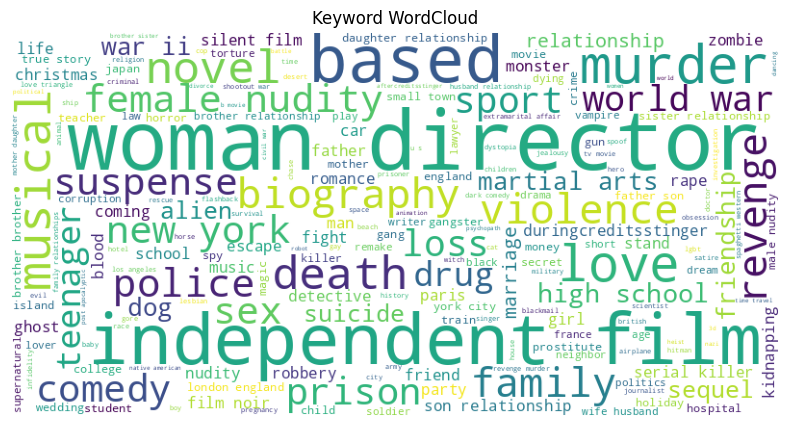

In [9]:
keywords["keywords"] = keywords["keywords"].apply(ast.literal_eval)

all_keywords = []
for row in keywords["keywords"]:
    for k in row:
        all_keywords.append(k["name"])

text = " ".join(all_keywords)

wc = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis("off")
plt.title("Keyword WordCloud")
plt.show()


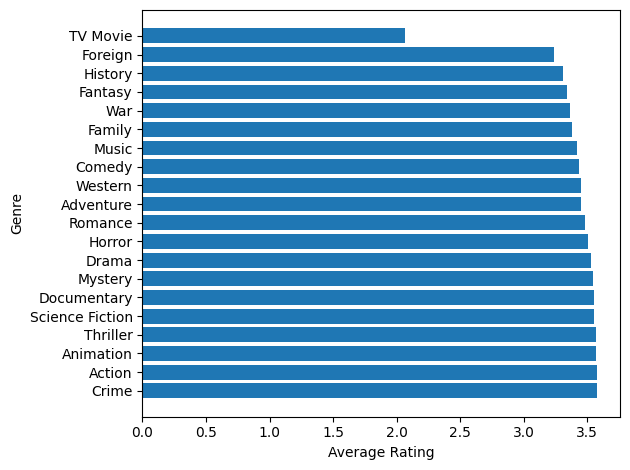

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

# --- 1. Safely extract genre names ---
def extract_genres(x):
    if isinstance(x, str):
        x = ast.literal_eval(x)
    return [g["name"] for g in x]

movies["genres_list"] = movies["genres_parsed"].apply(extract_genres)

# --- 2. Explode genres ---
movies_exploded = movies[["id", "genres_list"]].explode("genres_list")

# --- 3. Merge with ratings ---
ratings_with_genres = ratings.merge(
    movies_exploded,
    left_on="movieId",
    right_on="id",
    how="inner"
)

# --- 4. Compute average rating by genre ---
avg_rating_by_genre = (
    ratings_with_genres
    .groupby("genres_list")["rating"]
    .mean()
    .sort_values(ascending=False)
)

# --- 5. Plot ---
plt.figure()
plt.barh(avg_rating_by_genre.index, avg_rating_by_genre.values)
plt.xlabel("Average Rating")
plt.ylabel("Genre")
#plt.title("Average Rating by Genre")

plt.tight_layout()
plt.show()


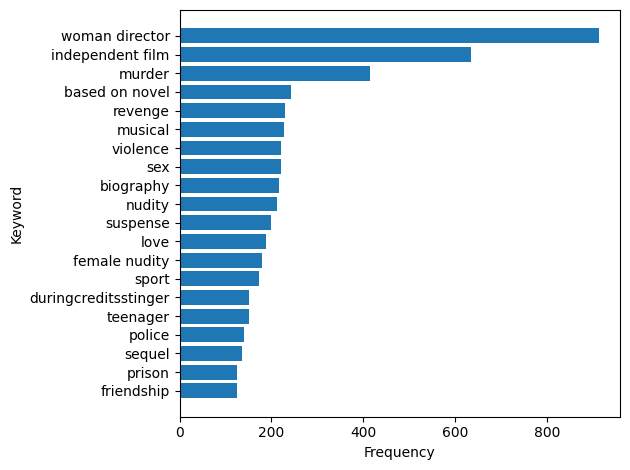

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import ast
from collections import Counter

# --- 1. Safely extract keyword names ---
def extract_keywords(x):
    if isinstance(x, str):
        x = ast.literal_eval(x)
    return [k["name"] for k in x]

keywords["keyword_list"] = keywords["keywords"].apply(extract_keywords)

# --- 2. Flatten all keywords ---
all_keywords = [
    kw
    for keyword_list in keywords["keyword_list"]
    for kw in keyword_list
]

# --- 3. Count keyword frequency ---
keyword_counts = Counter(all_keywords)
top_20 = dict(keyword_counts.most_common(20))

# --- 4. Prepare data ---
labels = list(top_20.keys())
values = list(top_20.values())

# --- 5. Plot horizontal bar chart ---
plt.figure()
plt.barh(labels, values)
plt.xlabel("Frequency")
plt.ylabel("Keyword")
#plt.title("Top 20 Most Frequent Keywords")

plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()
